In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm import tqdm
import torch
import tensorflow as tf
from transformers import create_optimizer
from scipy.special import softmax
from transformers import TFRobertaForSequenceClassification
from transformers import RobertaTokenizer, RobertaForSequenceClassification,RobertaTokenizerFast
from transformers import BartForConditionalGeneration, BartTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

c:\Users\Mihir\anaconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print("Number of GPU: ", torch.cuda.device_count())
print("GPU Name: ", torch.cuda.get_device_name())


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Number of GPU:  1
GPU Name:  NVIDIA GeForce RTX 3050 6GB Laptop GPU
Using device: cuda


In [3]:
df = pd.read_json('Baby_Products.jsonl',lines = True)

In [4]:
df.head()

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,4,Good buy for preschool naps and home use...,I bought two of these for my kids for nap time...,[],B004FM7VOW,B089MS68G8,AGKASBHYZPGTEPO6LWZPVJWB2BVA,2016-08-18 18:52:17,1,True
1,5,THEY WORK- and are super cute to boot...,LOVE THESE! AND THEY WORK!!! I was on the fenc...,[],B01E5E703G,B01E5E703G,AGKASBHYZPGTEPO6LWZPVJWB2BVA,2016-08-18 17:44:04,1,True
2,1,cute but small and pretty much unusable as a c...,cute but small and pretty much unusable as a c...,[],B00F463XV8,B00F9386Q8,AGKASBHYZPGTEPO6LWZPVJWB2BVA,2016-01-13 02:08:01,0,True
3,5,Works great perfect size!,I have lots of different disposable diaper bag...,[],B0007V644S,B07RRDX26B,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,2014-08-25 19:14:11,0,True
4,5,Cute and Works Great,I was so excited for bath time when I register...,[],B002LARFLY,B00OLRJET6,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,2012-10-09 21:42:41,0,False


In [5]:
df['asin'].value_counts()

asin
B00ECHYTBI    28280
B075QQ8VZW    17307
B001OC5UMQ    12840
B07F8HTSKD     8922
B0053X62GK     7491
              ...  
B09BPSN8MC        1
B07ZSVR2X7        1
B07Z6YYCGS        1
B001LK7E8E        1
B00LMK7HT4        1
Name: count, Length: 296394, dtype: int64

In [6]:
df = df[df['asin'] == 'B075QQ8VZW']

In [7]:
df.shape

(17307, 10)

In [8]:
df.isna().sum()

rating               0
title                0
text                 0
images               0
asin                 0
parent_asin          0
user_id              0
timestamp            0
helpful_vote         0
verified_purchase    0
dtype: int64

In [9]:
df = df.drop(columns=['title','images','parent_asin','user_id','helpful_vote'])

In [10]:
df = df[df['verified_purchase'] == True]

In [11]:
df.shape

(16857, 5)

In [12]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16857 entries, 167 to 6028581
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   rating             16857 non-null  int64         
 1   text               16857 non-null  object        
 2   asin               16857 non-null  object        
 3   timestamp          16857 non-null  datetime64[ns]
 4   verified_purchase  16857 non-null  bool          
dtypes: bool(1), datetime64[ns](1), int64(1), object(2)
memory usage: 674.9+ KB


## Performing Vader Sentiment Scoring

In [14]:
df['text']

167        Not sure if it’s worth it if it’s not complete...
235                                                   Great!
2562       Stores are sold out and this is so easy to use...
2656       Waste of money. It varies more than a degree b...
3026       Very easy to use, 1 button touch that accurate...
                                 ...                        
6027308    My toddler had so much fun with it(I am aware ...
6027323    Inaccurate readings. Very disappointed in this...
6028292    No pierdas tu tiempo ni tu dinero comprando esto!
6028415                                          Easy to use
6028581    Works great, and it doesn’t have to touch your...
Name: text, Length: 16857, dtype: object

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16857 entries, 167 to 6028581
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   rating             16857 non-null  int64         
 1   text               16857 non-null  object        
 2   asin               16857 non-null  object        
 3   timestamp          16857 non-null  datetime64[ns]
 4   verified_purchase  16857 non-null  bool          
dtypes: bool(1), datetime64[ns](1), int64(1), object(2)
memory usage: 674.9+ KB


In [28]:
vader_sentiment = SentimentIntensityAnalyzer()

In [29]:
example = df['text'].iloc[0]

In [30]:
example

'Not sure if it’s worth it if it’s not completely accurate'

In [31]:
vader_sentiment.polarity_scores(example)

{'neg': 0.153, 'neu': 0.7, 'pos': 0.148, 'compound': -0.016}

In [32]:
vader_data_sentiment = {}

for i in tqdm(range(df.shape[0])):
    rating = df['rating'].iloc[i]
    text = df['text'].iloc[i]
    timestamp = df['timestamp'].iloc[i]
    
    data = vader_sentiment.polarity_scores(text)
    neg = data['neg']
    neu = data['neu']
    pos = data['pos']
    
    vader_data_sentiment[i] = [rating, text, timestamp, neg, neu, pos]

100%|██████████| 16857/16857 [00:03<00:00, 4637.66it/s]


In [33]:
vader_data_sentiment = {}

for i in tqdm(range(df.shape[0])):
    rating = df['rating'].iloc[i]
    text = df['text'].iloc[i]
    timestamp = df['timestamp'].iloc[i]
    
    data = vader_sentiment.polarity_scores(text)
    neg = data['neg']
    neu = data['neu']
    pos = data['pos']
    
    vader_data_sentiment[i] = [rating, text, timestamp, neg, neu, pos]

100%|██████████| 16857/16857 [00:03<00:00, 4729.89it/s]


In [34]:
vader_df = pd.DataFrame.from_dict(
    vader_data_sentiment,
    orient='index',
    columns=['rating', 'text', 'timestamp', 'neg', 'neu', 'pos']
)

In [35]:
data = dict(sorted(dict(vader_df['rating'].value_counts()).items()))
keys = list(data.keys())
values = list(data.values())

### Distribution of the Ratings

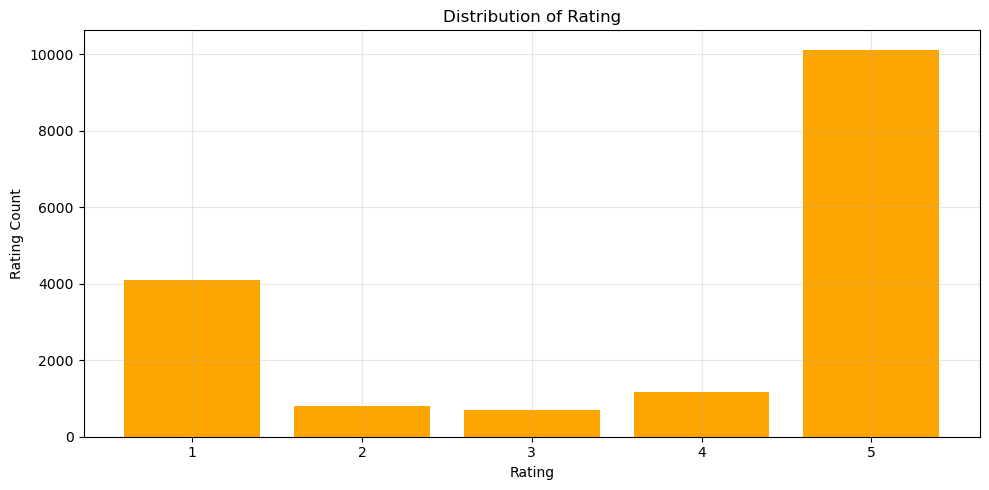

In [36]:
plt.figure(figsize = (10,5))
plt.bar(keys,values,color = 'orange')
plt.title('Distribution of Rating')
plt.xlabel('Rating')
plt.ylabel('Rating Count')
plt.grid(alpha = 0.3)
plt.tight_layout()


### Distribution of the Sentiments captured by the Vader

In [37]:
vader_df['label'] = vader_df[['neg', 'neu', 'pos']].idxmax(axis=1)

In [38]:
neu_score = vader_df[vader_df['label'] == 'neu']
pos_score = vader_df[vader_df['label'] == 'pos']
neg_score = vader_df[vader_df['label'] == 'neg']

In [39]:
def get_data(data):
    data = dict(sorted(dict(data['rating'].value_counts()).items()))
    keys = list(data.keys())
    values = list(data.values())
    return keys,values

neu_score_key , neu_score_value = get_data(neu_score)
pos_score_key , pos_score_value = get_data(pos_score)
neg_score_key , neg_score_value = get_data(neg_score)

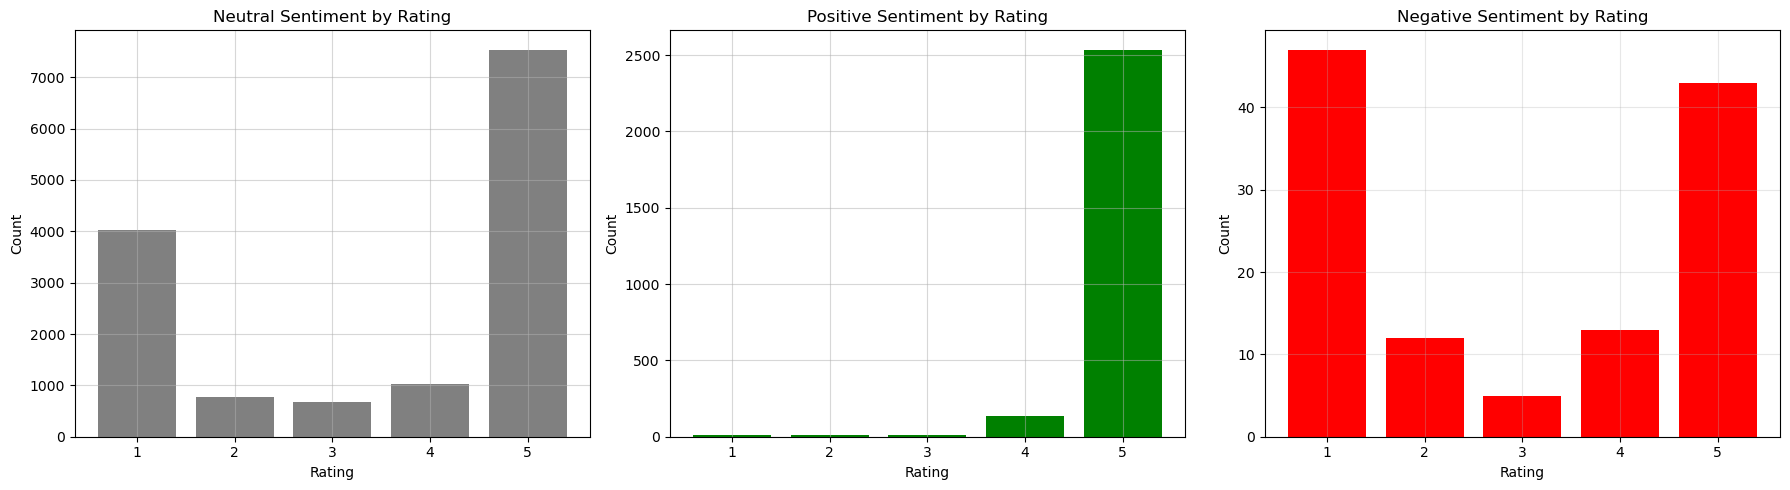

In [40]:
fig , arr = plt.subplots(1,3,figsize = (18,5))

arr[0].bar(neu_score_key, neu_score_value, color='gray')
arr[0].set_title('Neutral Sentiment by Rating')
arr[0].set_xlabel('Rating')
arr[0].set_ylabel('Count')
arr[0].grid(True, alpha=0.5)

arr[1].bar(pos_score_key, pos_score_value, color='green')
arr[1].set_title('Positive Sentiment by Rating')
arr[1].set_xlabel('Rating')
arr[1].set_ylabel('Count')
arr[1].grid(True, alpha=0.5)

arr[2].bar(neg_score_key, neg_score_value, color='red')
arr[2].set_title('Negative Sentiment by Rating')
arr[2].set_xlabel('Rating')
arr[2].set_ylabel('Count')
arr[2].grid(True, alpha=0.3)

plt.tight_layout()

### Performing RoBERTa To perform Sentiments

In [26]:
path = "Roberta_model"
tokenizer = RobertaTokenizer.from_pretrained(path)
model = RobertaForSequenceClassification.from_pretrained(path, num_labels=3) 

model.eval()

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

### Performing RoBERTa To perform Sentiments

In [27]:
def polarity_score(example):

    encoded_text = tokenizer(example,return_tensors = 'pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict


In [56]:
path = 'saved_model'
summarizer = BartForConditionalGeneration.from_pretrained(path)
summarizer_tokenizer = BartTokenizer.from_pretrained(path)      

c:\Users\Mihir\anaconda3\Lib\site-packages\transformers\models\bart\configuration_bart.py:176: UserWarning: Please make sure the config includes `forced_bos_token_id=0` in future versions. The config can simply be saved and uploaded again to be fixed.
  warnings.warn(


In [57]:
def summarize_text(text, max_length=200):
    word_count = len(text.split())
    
    if word_count > 100: 
        max_length = max(50, int(0.5 * word_count))
        min_length = max(20, int(0.2 * word_count))
        
        words = text.split()
        trimmed_text = " ".join(words[:300])

        inputs = summarizer_tokenizer(trimmed_text, return_tensors="pt", max_length=1024, truncation=True)
        summary_ids = summarizer.generate(
            inputs["input_ids"], 
            max_length=max_length, 
            min_length=min_length,
            num_beams=4, 
            early_stopping=True
        )
        summary = summarizer_tokenizer.decode(summary_ids[0], skip_special_tokens=True)
        return summary

    return text


In [58]:
df['text'] = df['text'].apply(summarize_text)

c:\Users\Mihir\anaconda3\Lib\site-packages\transformers\generation\utils.py:1581: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed in v5. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


In [46]:
result = {}

for i in tqdm(range(df.shape[0])):
    index = i
    rating = df['rating'].iloc[i]
    text = df['text'].iloc[i]
    timestamp = df['timestamp'].iloc[i]
        
    score = polarity_score(text)
    roberta_neg = score['roberta_neg']
    roberta_neu = score['roberta_neu']
    roberta_pos = score['roberta_pos']

    result[index] = [rating,text,timestamp,roberta_neg,roberta_neu,roberta_pos]

100%|██████████| 16857/16857 [15:25<00:00, 18.22it/s]


In [47]:
new_df = pd.DataFrame.from_dict(
    result,
    orient='index',
    columns=['rating', 'text', 'timestamp', 'rob_neg', 'rob_neu', 'rob_pos']
)

In [48]:
new_df.head()

,rating,text,timestamp,rob_neg,rob_neu,rob_pos
0,4,Not sure if it’s worth it if it’s not complete...,2022-12-01 02:17:07.139,0.525368,0.451032,0.023600
1,5,Great!,2022-06-28 15:41:41.830,0.007591,0.069169,0.923240
2,5,Stores are sold out and this is so easy to use...,2022-12-23 15:49:52.046,0.003544,0.022164,0.974292
3,1,Waste of money. It varies more than a degree b...,2020-08-21 11:37:54.561,0.911902,0.078397,0.009701
4,5,"Very easy to use, 1 button touch that accurate...",2020-10-21 17:54:19.216,0.003531,0.081844,0.914625


In [49]:
new_df.to_csv('sentiment_scored.csv')

# Evaluation of RoBERTa sentiment scores to determine whether they can be considered as ground truth.

### Assigning Sample_structured_data

In [28]:
new_df = pd.read_csv('sentiment_scored.csv')

In [29]:
new_df.drop(columns=['Unnamed: 0'],inplace=True)

In [30]:
sample_structured_data = []
count = 0
j = 0

while count < 300:
    data = new_df['text'].iloc[j]
    if len(data) > 100:
        sample_structured_data.append([data, 0]) 
        count += 1
    j += 1



In [31]:
sample_df = pd.DataFrame(sample_structured_data, columns=['text', 'sentiment'])

In [32]:
# sample_df.to_csv('sample_df_.csv')

In [33]:
sample_data = pd.read_csv('sample_df_.csv')

In [34]:
postive = []
negative = []
neutral = []

for i in tqdm(range(sample_data.shape[0])):
    index = i
    text = sample_data['text'].iloc[i]
        
    score = polarity_score(text)
    roberta_neg = score['roberta_neg']
    roberta_neu = score['roberta_neu']
    roberta_pos = score['roberta_pos']

    postive.append(roberta_pos)
    negative.append(roberta_neg)
    neutral.append(roberta_neu)

100%|██████████| 300/300 [00:19<00:00, 15.42it/s]


In [35]:
sample_data['positive'] = postive
sample_data['negative'] = negative
sample_data['neutral'] = neutral

In [36]:
sample_data.head()

,Unnamed: 0,text,sentiment_score,positive,negative,neutral
0,0,Best feature of this is being able to use it o...,1,0.976770,0.002939,0.020291
1,1,Always between 97.3 and 97.8. Tested with 2 ot...,-1,0.014102,0.852254,0.133644
2,2,"I can't say if this is the one at fault, might...",0,0.036534,0.464497,0.498969
3,3,The product is very easy to use. Any age group...,1,0.956808,0.002442,0.040750
4,4,Got one for each family member. Good design an...,1,0.889818,0.003166,0.107016


In [37]:
sample_data['roberta_label'] = sample_data[['negative', 'neutral', 'positive']].idxmax(axis=1)

In [38]:
map_ = {
    'positive' : 1,
    'negative' : -1,
    'neutral' : 0
}

sample_data['roberta_label'] = sample_data['roberta_label'].map(map_)

In [39]:
sample_data.head()

,Unnamed: 0,text,sentiment_score,positive,negative,neutral,roberta_label
0,0,Best feature of this is being able to use it o...,1,0.976770,0.002939,0.020291,1
1,1,Always between 97.3 and 97.8. Tested with 2 ot...,-1,0.014102,0.852254,0.133644,-1
2,2,"I can't say if this is the one at fault, might...",0,0.036534,0.464497,0.498969,0
3,3,The product is very easy to use. Any age group...,1,0.956808,0.002442,0.040750,1
4,4,Got one for each family member. Good design an...,1,0.889818,0.003166,0.107016,1


In [40]:
score = f1_score(sample_data['sentiment_score'], sample_data['roberta_label'], average='weighted')
print(f'f1-score of the sample labeled data is {score:.2f}')

f1-score of the sample labeled data is 0.72


### The F1 score indicates that we cannot consider RoBERTa as the ground truth, meaning fine-tuning the transformer is important.

## Fine-tuning the model

In [41]:
model = TFRobertaForSequenceClassification.from_pretrained(path, num_labels=3)

All PyTorch model weights were used when initializing TFRobertaForSequenceClassification.

All the weights of TFRobertaForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


##  Prepare the Data

In [42]:
sample_data = sample_data.drop(columns=['Unnamed: 0'])

In [43]:
texts = sample_data['text'].tolist()
labels = sample_data['sentiment_score'].map({-1: 0, 0: 1, 1: 2}).tolist()

train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2)

In [44]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [45]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
)).batch(16)

In [46]:

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
)).batch(16)

## Compile and Train the Model 

In [47]:
early_stopping = tf.keras.callbacks.EarlyStopping(
     monitor='val_accuracy', 
    patience=2,           
    mode='max',             
    restore_best_weights=True
)

In [48]:
num_train_steps = len(train_dataset) * 3 
optimizer, schedule = create_optimizer(init_lr=2e-5, num_warmup_steps=0, num_train_steps=num_train_steps)

model.compile(optimizer=optimizer, 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])

model.fit(train_dataset, validation_data=val_dataset, epochs=10,callbacks=early_stopping)

Epoch 1/10


15/15 [==============================] - 91s 4s/step - loss: 0.5665 - accuracy: 0.8083 - val_loss: 0.4132 - val_accuracy: 0.7833
Epoch 2/10
15/15 [==============================] - 52s 3s/step - loss: 0.3494 - accuracy: 0.8708 - val_loss: 0.4167 - val_accuracy: 0.7667
Epoch 3/10
15/15 [==============================] - 52s 3s/step - loss: 0.2993 - accuracy: 0.9042 - val_loss: 0.4045 - val_accuracy: 0.8000
Epoch 4/10
15/15 [==============================] - 53s 4s/step - loss: 0.2938 - accuracy: 0.9042 - val_loss: 0.4045 - val_accuracy: 0.8000
Epoch 5/10
15/15 [==============================] - 52s 4s/step - loss: 0.2943 - accuracy: 0.9125 - val_loss: 0.4045 - val_accuracy: 0.8000


## Evaluation and Save

In [49]:
model.save_pretrained("roberta_finetuned_tf")
tokenizer.save_pretrained("roberta_finetuned_tf")

('roberta_finetuned_tf\\tokenizer_config.json',
 'roberta_finetuned_tf\\special_tokens_map.json',
 'roberta_finetuned_tf\\vocab.json',
 'roberta_finetuned_tf\\merges.txt',
 'roberta_finetuned_tf\\added_tokens.json')

In [50]:
model = TFRobertaForSequenceClassification.from_pretrained("roberta_finetuned_tf")
tokenizer = RobertaTokenizerFast.from_pretrained("roberta_finetuned_tf")

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at roberta_finetuned_tf.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


In [54]:
def polarity_score(example):
    encoded_text = tokenizer(example, return_tensors='tf', truncation=True, padding=True)
    output = model(**encoded_text)
    scores = output.logits.numpy()[0]
    scores = softmax(scores)

    return {
        'roberta_neg': float(scores[0]),
        'roberta_neu': float(scores[1]),
        'roberta_pos': float(scores[2])
    }

In [60]:
result = {}

for i in tqdm(range(df.shape[0])):
    index = i
    rating = df['rating'].iloc[i]
    text = df['text'].iloc[i]
    timestamp = df['timestamp'].iloc[i]
        
    score = polarity_score(text)
    roberta_neg = score['roberta_neg']
    roberta_neu = score['roberta_neu']
    roberta_pos = score['roberta_pos']

    result[index] = [rating,text,timestamp,roberta_neg,roberta_neu,roberta_pos]

  0%|          | 0/16857 [00:00<?, ?it/s]

100%|██████████| 16857/16857 [58:39<00:00,  4.79it/s] 


In [61]:
new_df = pd.DataFrame.from_dict(
    result,
    orient='index',
    columns=['rating', 'text', 'timestamp', 'rob_neg', 'rob_neu', 'rob_pos']
)

In [62]:
new_df.to_csv()

',rating,text,timestamp,rob_neg,rob_neu,rob_pos\r\n0,4,Not sure if it’s worth it if it’s not completely accurate,2022-12-01 02:17:07.139,0.36855003237724304,0.22849681973457336,0.4029531478881836\r\n1,5,Great!,2022-06-28 15:41:41.830,0.008856605738401413,0.009405468590557575,0.9817379117012024\r\n2,5,Stores are sold out and this is so easy to use and read! I recommend this.,2022-12-23 15:49:52.046,0.008806698955595493,0.0033478187397122383,0.9878454804420471\r\n3,1,Waste of money. It varies more than a degree between repeat scans. Ugh!,2020-08-21 11:37:54.561,0.5263051390647888,0.14027170836925507,0.3334231674671173\r\n4,5,"Very easy to use, 1 button touch that accurately records temp.",2020-10-21 17:54:19.216,0.005979418754577637,0.003747608046978712,0.9902729392051697\r\n5,5,Best feature of this is being able to use it on a sleeping person. You can check a kids temperature without waking him/her up. Love it!!!,2022-03-07 01:18:19.085,0.00823674350976944,0.003451030468568206,0.9883121